# Variational Quantum Eigensolver

The Variational Quantum Eigensolver (VQE) is used to find eigenvalues of a matrix $H$, which is often too large to perform a similar operation on a classical computer. The problem of finding eigenvalues appears in many areas such as optimization, quantum simulations or quantum chemistry.

In this notebook, we will implement VQE in Python just using `numpy` and `sympy` as quantum computer simulator in order to solve one of the tasks of [Quantum Computing Mentorship Program](https://qosf.org/qc_mentorship/). 

Firstly we will get a grasp on theory but a **basic quantum mechanics knowledgement is required**.

## VQE Theory

Assume, we want to know the lowest eigenvalue $\lambda_1$ of Hermitian matrix $H$. The VQE algorithm uses a quantum subroutine inside a classical minimization task. The quantum subroutine consists of two parts

- Prepare a quantum state $|\psi({\theta})\rangle$

- Measure the expectation value of $H$ in the state $|\psi({\theta})\rangle$, which is denoted by:

$$\langle H \rangle = \langle\psi({\theta})|H|\psi({\theta})\rangle$$

According to the [variational theorem](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)), the expectation value is always greater or equal to the lowest eigenvalue

$$\langle H \rangle \geqslant \lambda_1$$

Our problem boils down to finding such an optimal choice of real-valued $\theta$ parameters, that the expectation value is minimized and an approximate of the lowest eigenvalue is found.

Now, the classical optimization enters the game. Thanks to the quantum subroutine, we get an expectation value dependent on $\theta$ parameters. This value can be minimized with a gradient-free optimization method such as [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) method.

## Problem

We will search for the lowest eigenvalue of the following Hamiltonian

$$H = \quad\begin{pmatrix} 
1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1
\end{pmatrix}$$

So first we need to decompose this matrix on sum of [Pauli](https://en.wikipedia.org/wiki/Pauli_matrices) terms. Then we can rewrite $H$ as

$$ H = \frac{1}{2} I\otimes I + \frac{1}{2} Z\otimes Z - \frac{1}{2} Y\otimes Y - \frac{1}{2} X\otimes X $$

where $\otimes$ means tensorial product and Pauli terms corresponds with

$$
I=\quad\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix},
Z=\quad\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix},
Y=\quad\begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix},
X=\quad\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}
$$

## Implementation

### Preliminars

We will use `numpy` and `sympy` for calculating the previous Hamiltonian by two ways

1) Only using `sympy` and matrix products

2) Perform a simple quantum circuits using `numpy`.

So first let's import some objects required.

In [1]:
import numpy as np
from numpy import linalg as la
from scipy.linalg import norm
from sympy import Symbol, Matrix, diag, eye, cos, sin, exp, pi, lambdify
from sympy.physics.quantum import Dagger, TensorProduct
import matplotlib.pyplot as plt

#### Sympy

We will define our **qubits** and [quantum gates](https://en.wikipedia.org/wiki/Quantum_logic_gate)

In [2]:
theta = Symbol("theta", real=True)
j = np.complex(0,1)

# qubits
ket_0 = Matrix([[1], [0]])
ket_1 = Matrix([[0], [1]])

# identity, hadamard and CNOT gates
I = Matrix([[1, 0], [0, 1]])
H = 1/np.sqrt(2) * Matrix([[1, 1], [1, -1]])
cx = diag(eye(2), Matrix([[0, 1], [1, 0]]))

# pauli gates
pauli_x = Matrix([[0, 1], [1, 0]])
pauli_y = Matrix([[0, -j], [j, 0]])
pauli_z = Matrix([[1, 0], [0, -1]])

# rotational gates wiht a theta parameter
ry = Matrix([[cos(theta/2), -sin(theta/2)], [sin(theta/2), cos(theta/2)]])
rx = Matrix([[cos(theta/2), -j*sin(theta/2)], [-j*sin(theta/2), cos(theta/2)]])
#rz = Matrix([[exp((-j*theta/2)), 0], [0, exp((j*theta/2))]])
rz = Matrix([[cos(theta/2) -j*sin(theta/2), 0], [0, cos(theta/2) +j*sin(theta/2)]])

We are going to start with a state $|00\rangle$ as usual on a quantum circuits in order to prepare a state called **ansatz**. We can define an ansatz as the routine that takes parameters as an input and prepares a quantum state $|\psi({\theta})\rangle$ which is used to do some calculations. Also this states are vectors on a 4-dimensional Hilbert space so we have to construct the corresponding gates that acts on each particular qubit.

Our ansatz will be $Rx_1(\theta) C_{NOT} H_1|00\rangle$

In [3]:
II = TensorProduct(I, I)
ZZ = TensorProduct(pauli_z, pauli_z)
YY = TensorProduct(pauli_y, pauli_y)
XX = TensorProduct(pauli_x, pauli_x)
hamiltonian = 1/2*II + 1/2*ZZ - 1/2*YY - 1/2*XX

ry1 = TensorProduct(ry, I)
ry2 = TensorProduct(I, ry)
ryry = TensorProduct(ry, ry)

rx1 = TensorProduct(rx, I)
rx2 = TensorProduct(I, rx)
rxrx = TensorProduct(rx, rx)

#ansatz = TensorProduct(ry, I) * cx * TensorProduct(H * ket_0, ket_0)
ansatz = TensorProduct(rx, I) * cx * TensorProduct(H * ket_0, ket_0)
print("ansatz")
ansatz

ansatz


Matrix([
[   0.707106781186547*cos(theta/2)],
[-0.707106781186547*I*sin(theta/2)],
[-0.707106781186547*I*sin(theta/2)],
[   0.707106781186547*cos(theta/2)]])

Once we have prepared our state let's do some calculations. Firts we calculate four terms of our Hamiltonian and then the corresponding expected value. We have to care about one thing: in spite of we operate over our ansatz, in a real quantum computer we have to implement a mechanism to do measurements on a quantum basis, this is the basis $|0\rangle$ and $|1\rangle$ in the $Z$ axis. For this reason we manipulate our ansatz in order to create two new states `ansataz_x` and `ansatz_y`.

In [4]:
H_i = ansatz.conjugate().T * II * ansatz
H_z = ansatz.conjugate().T * ZZ * ansatz

# ansatz_x for H_x | rotate -pi/2 over Y axis
#ansatz_x = ry1.subs(theta, -np.pi/2) * ry2.subs(theta, -np.pi/2) * ansatz
ansatz_x = ryry.subs(theta, -np.pi/2) * ansatz
H_x = ansatz_x.conjugate().T * ZZ * ansatz_x

# ansatz_y for H_y | rotate pi/2 over X axis
#ansatz_y = rx1.subs(theta, np.pi/2) * rx2.subs(theta, np.pi/2) * ansatz
ansatz_y = rxrx.subs(theta, np.pi/2) * ansatz
H_y = ansatz_y.conjugate().T * ZZ * ansatz_y

expected = 1/2*H_i + 1/2*H_z - 1/2*H_y - 1/2*H_x
print("Hamiltonian expected value as function of theta parameter: ")
expected

Hamiltonian expected value as function of theta parameter: 


Matrix([[-1.0*(-0.707106781186547*I*sin(theta/2) + 0.707106781186547*cos(theta/2))*(0.707106781186547*I*sin(theta/2) + 0.707106781186547*cos(theta/2)) - 0.5*(-1.57009245868378e-16*I*sin(theta/2) - I*cos(theta/2))**2 - 0.5*(-sin(theta/2) + 1.57009245868378e-16*cos(theta/2))**2 + 1.23259516440783e-32*sin(theta/2)**2 + 1.0*cos(theta/2)**2]])

Finally the expectation value of $H$ is measured in the state ansatz and a minimum is found by varying parameters $\theta$.

Note: we are not going to implement an algorithm that minimize $\theta$ parameter.

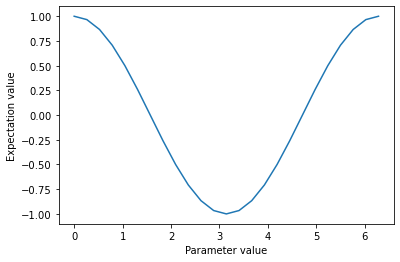

Minimal Eigenvalue:  -1.00000000000000


In [5]:
theta_range = np.linspace(0.0, 2 * np.pi, 25)

data = [expected.subs(theta, i).evalf(chop=True)[0] for i in theta_range]

plt.xlabel("Parameter value")
plt.ylabel("Expectation value")
plt.plot(theta_range, data)
plt.show()

print("Minimal Eigenvalue: ", min(data))

And this value is the minimal of the four eigenvalues of the Hamiltonian

In [6]:
hamiltonian = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
e_vals, e_vecs = la.eig(hamiltonian)
e_vals

array([ 1., -1.,  1.,  1.])

#### Numpy

On the previous section we performed a VQE using `sympy` and explicit matrix calculations. Part of this tasks consists on define a quantum gate as a matrix $2^N$ dimensional where $N$ is the number of qubits. This because we represent a system of $N$ qubits as a point on $2^N$ dimensional Hilbert space. For example, a system of 4 qubits can be written as

$$|0010\rangle = |0\rangle_1\otimes |0\rangle_2\otimes|1\rangle_3\otimes|0\rangle_4$$

You can see how hard is define a matrix that operate on the following qubit system $|100111001101011100001011100100001\rangle$

In order to deal with this topic we can improve a more efficient implementation using `numpy`. Also, `numpy` allows us to develop a more realistic quantum simulator.

Note: we still use `sympy` to deal with a parameter $\theta$.

In [7]:
j = np.complex(0, 1)

# identity, hadamard and CNOT gates
I = np.array([[1, 0], [0, 1]])
H_matrix = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
CNOT_matrix = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,0,1],
                        [0,0,1,0]])

CNOT_tensor = np.reshape(CNOT_matrix, (2,2,2,2))

# pauli gates
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -j], [j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

# n qubits
class Reg: 
    def __init__(self, n):
        self.n = n
        self.psi = np.zeros((2,) * n) 
        self.psi[(0,) * n] = 1        
    
def H(i, reg):
    reg.psi = np.tensordot(H_matrix, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Z(i, reg):
    reg.psi = np.tensordot(pauli_z, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def X(i, reg):
    reg.psi = np.tensordot(pauli_x, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Y(i, reg):
    reg.psi = np.tensordot(pauli_y, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Ry(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    ry = Matrix([[cos(angle/2), -sin(angle/2)], [sin(angle/2), cos(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(ry, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(ry.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Rx(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    j = np.complex(0, 1)
    rx = Matrix([[cos(angle/2), -j*sin(angle/2)], [-j*sin(angle/2), cos(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(rx, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(rx.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Rz(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    j = np.complex(0, 1)
    #rz = Matrix([[exp((-j*theta/2)), 0], [0, exp((j*theta/2))]])
    rz = Matrix([[cos(angle/2) -j*sin(angle/2), 0], [0, cos(angle/2) +j*sin(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(rz, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(rz.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)

def CNOT(control, target, reg):
    reg.psi = np.tensordot(CNOT_tensor, reg.psi, ((2,3), (control, target))) 
    reg.psi = np.moveaxis(reg.psi, (0, 1), (control, target))   

def measure(i, reg): 
    projectors = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])] 
    
    def project(i, j, reg): 
        projected = np.tensordot(projectors[j], reg.psi, (1, i))
        return np.moveaxis(projected, 0, i)
    
    projected = project(i, 0, reg) 
    norm_projected = norm(projected.flatten()) 
    if np.random.random() < norm_projected ** 2: 
        reg.psi = projected/norm_projected
        return 0
    else:
        projected = project(i, 1, reg)
        reg.psi = projected/norm(projected)
        return 1

We defined each quantum gate as a `function` that operate on a register `reg`. This register is a `class` initializated with the number of qubits we want and it contains the ket $|0..\rangle$. For example, if we want 1 and 10 qubits

In [8]:
reg_0 = Reg(1)
reg_0.psi.flatten()

array([1., 0.])

In [9]:
reg_10 = Reg(10)
reg_10.psi.flatten()

array([1., 0., 0., ..., 0., 0., 0.])

And if we apply Hadamard gate on $|0\rangle$ we obtain

In [10]:
H(0, reg_0)
reg_0.psi.flatten()

array([0.70710678, 0.70710678])

Now we can implement a VQE defining a simple quantum circuits.

In [11]:
reg_z = Reg(2)

H(0, reg_z)
CNOT(0, 1, reg_z)
Rx(0, reg_z)

ansatz_z = reg_z.psi.flatten()
Z(0, reg_z)
Z(1, reg_z)

expected_z = 1/2 * np.dot(ansatz_z.conjugate(), reg_z.psi.flatten())
expected_I = 1/2 * np.dot(ansatz_z.conjugate(), ansatz_z)

reg_x = Reg(2)

H(0, reg_x)
CNOT(0, 1, reg_x)
Rx(0, reg_x)

# ansatz_x for H_x | rotate -pi/2 over Y axis
Ry(0, reg_x, angle_value=-np.pi/2)
Ry(1, reg_x, angle_value=-np.pi/2)
ansatz_x = reg_x.psi.flatten()
Z(0, reg_x)
Z(1, reg_x)

expected_x = -1/2 * np.dot(ansatz_x.conjugate(), reg_x.psi.flatten())

reg_y = Reg(2)

H(0, reg_y)
CNOT(0, 1, reg_y)
Rx(0, reg_y)

# ansatz_y for H_y | rotate pi/2 over X axis
Rx(0, reg_y, angle_value=np.pi/2)
Rx(1, reg_y, angle_value=np.pi/2)
ansatz_y = reg_y.psi.flatten()
Z(0, reg_y)
Z(1, reg_y)

expected_y = -1/2 * np.dot(ansatz_y.conjugate(), reg_y.psi.flatten())

On the previous code we have defined 3 `register` as ansatz and then we apllied differents quantum gates on them (to measure in quantum basis as we did on `sympy` code). Why not just 1 `register`? Well, the habitual procedure on quantum computing is prepare an ansatz, let that state evoluting by the action of Hamiltonian, measure and repeat. So in this approach we can prepare the same ansatz and apply parts of our Hamiltonian considering as a simple Hamiltonian itself

$$ 
H = \frac{1}{2} I\otimes I + \frac{1}{2} Z\otimes Z - \frac{1}{2} Y\otimes Y - \frac{1}{2} X\otimes X = 
\frac{1}{2} H_I + \frac{1}{2} H_z - \frac{1}{2} H_y - \frac{1}{2} H_x
$$

$$ 
H|\psi({\theta})\rangle = 
\frac{1}{2} H_I|\psi({\theta})\rangle 
+ \frac{1}{2} H_z|\psi({\theta})\rangle 
- \frac{1}{2} H_y|\psi_y({\theta})\rangle 
- \frac{1}{2} H_x|\psi_x({\theta})\rangle
$$

where 
$$|\psi({\theta})\rangle = Rx_1(\theta)C_{NOT}H_1|00\rangle$$

$$|\psi_x({\theta})\rangle = Rx_1\left(\frac{\pi}{2}\right) Rx_2\left(\frac{\pi}{2}\right) Rx_1(\theta)C_{NOT}H_1|00\rangle$$

$$|\psi_y({\theta})\rangle = Ry_1\left(\frac{-\pi}{2}\right) Ry_2\left(\frac{-\pi}{2}\right)Rx_1(\theta)C_{NOT}H_1|00\rangle$$

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


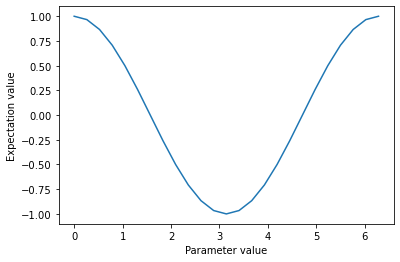

Minimal Eigenvalue:  (-0.9999999999999991+0j)


In [12]:
expected = expected_I + expected_z + expected_x + expected_y
theta_range = np.linspace(0.0, 2 * np.pi, 25)
f = lambdify(theta, expected, "numpy")
data = f(theta_range)

plt.xlabel("Parameter value")
plt.ylabel("Expectation value")
plt.plot(theta_range, data)
plt.show()
print("Minimal Eigenvalue: ", min(data))

And this is the same result we obtain on previous section.

## References

[Quantum Open Source Foundation](https://qosf.org/)

Quantum Computation and Quantum Information (Michael A. Nielsen, Isaac L. Chuang)

[A variational eigenvalue solver on a photonic quantum processor](https://www.nature.com/articles/ncomms5213)

[Subspace-search variational quantum eigensolver for excited states](https://arxiv.org/abs/1810.09434)